In [1]:
import sys

sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from partition import EmbeddingsPartition
from projections import SimplexProjection

import numpy as np
import matplotlib.pyplot as plt
from imblearn.datasets import fetch_datasets


ecoli = fetch_datasets()['ecoli']
X = ecoli.data
y = ecoli.target

minor_class = np.min(y)
train_embeddings = X[y == minor_class]
test_embeddings = X[y != minor_class]

print(len(test_embeddings), len(train_embeddings))

# np.random.seed(42)
# test_sample_indices = np.random.choice(test_embeddings_full.shape[0], min(1000, len(test_embeddings_full)), replace=False)
# test_embeddings = test_embeddings_full[test_sample_indices]

max_k = 11
max_t = 11
t_values = range(1, max_t + 1, 2)
k_values = range(1, max_k + 1)

partitioner = EmbeddingsPartition(train_embeddings, dimension=train_embeddings.shape[1])

all_projections = {t: [] for t in t_values}

def filter_simplexes_by_size(simplexes, size):
    return [simplex for simplex in simplexes if len(simplex) == size]

for t in t_values:
    print(f"Building simplexes with max_k={max_k} and t={t}")
    all_simplexes = partitioner.run_method("clique", k=max_k, t=t)
    print(len(all_simplexes))

    for k in k_values:
        print(f"Filtering simplexes to size t={t} for k={k}")
        filtered_simplexes = filter_simplexes_by_size(all_simplexes, k)
        print(len(filtered_simplexes))

        simplex_projection = SimplexProjection(filtered_simplexes)

        projections = simplex_projection.find_closest_projections(test_embeddings)
        if projections[0].sum() == 0:
            all_projections[t].append([])
            continue
        distances = np.linalg.norm(test_embeddings - projections, axis=1)
        mean_distance = np.mean(distances)
        all_projections[t].append(projections)

        print(f"Mean distance for t={t}, k={k}: {mean_distance}")

35 301
Building simplexes with max_k=11 and t=1
301
Filtering simplexes to size t=1 for k=1
301
Mean distance for t=1, k=1: 0.11977525028674883
Filtering simplexes to size t=1 for k=2
0
Filtering simplexes to size t=1 for k=3
0
Filtering simplexes to size t=1 for k=4
0
Filtering simplexes to size t=1 for k=5
0
Filtering simplexes to size t=1 for k=6
0
Filtering simplexes to size t=1 for k=7
0
Filtering simplexes to size t=1 for k=8
0
Filtering simplexes to size t=1 for k=9
0
Filtering simplexes to size t=1 for k=10
0
Filtering simplexes to size t=1 for k=11
0
Building simplexes with max_k=11 and t=3
822
Filtering simplexes to size t=3 for k=1
301
Mean distance for t=3, k=1: 0.11977525028674883
Filtering simplexes to size t=3 for k=2
439
Mean distance for t=3, k=2: 0.10901882065242015
Filtering simplexes to size t=3 for k=3
82
Mean distance for t=3, k=3: 0.13607722330996658
Filtering simplexes to size t=3 for k=4
0
Filtering simplexes to size t=3 for k=5
0
Filtering simplexes to size t=

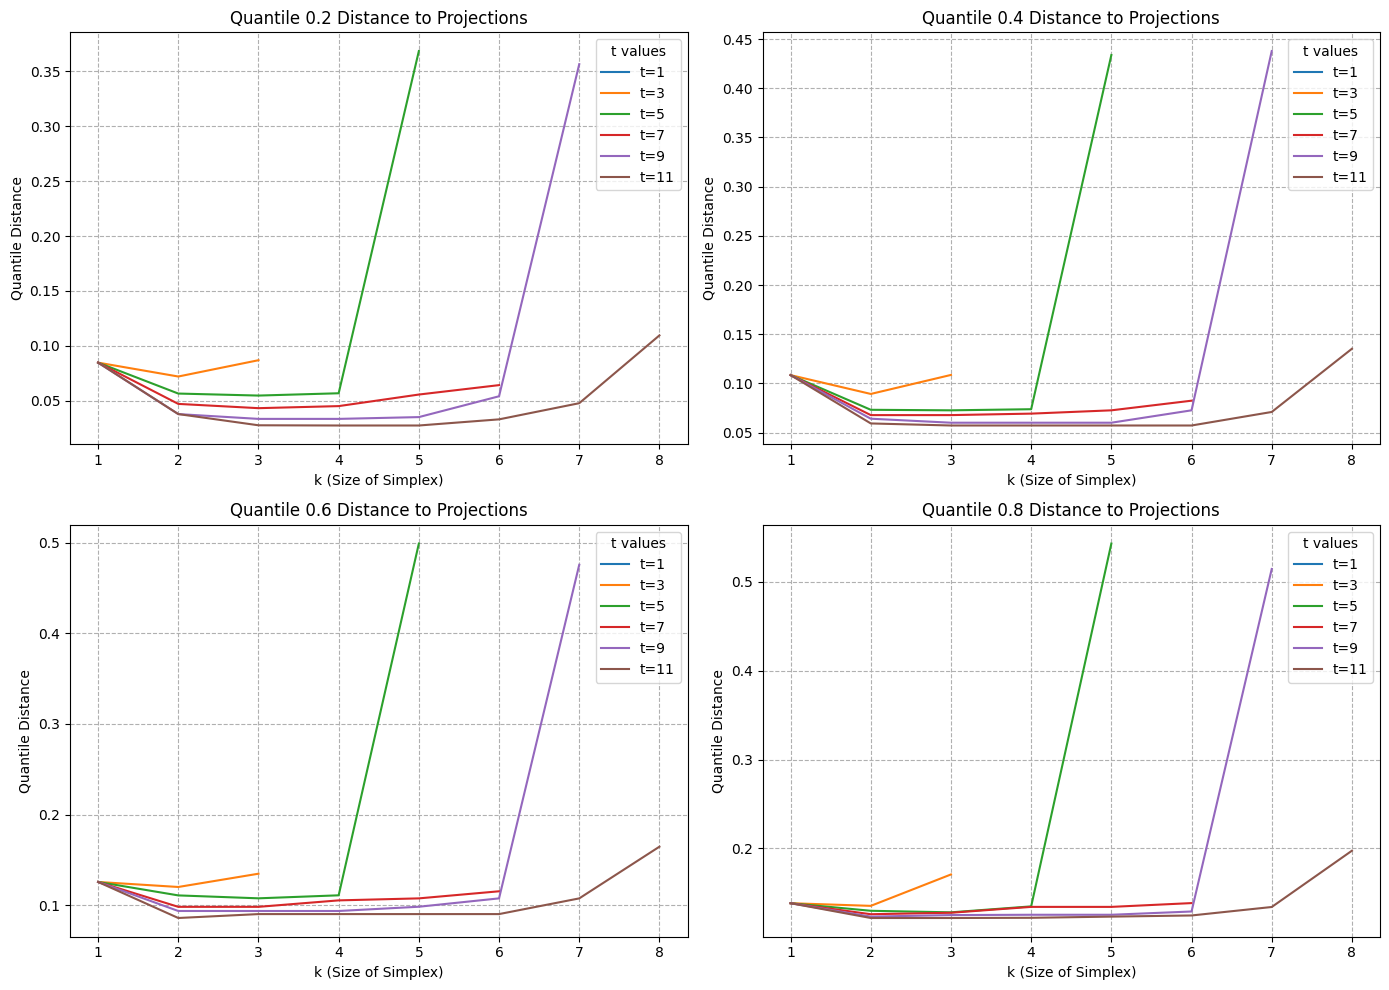

In [9]:
import numpy as np
import matplotlib.pyplot as plt

quantiles = [0.2, 0.4, 0.6, 0.8]
quantile_results = {t: {q: [] for q in quantiles} for t in t_values}

def calculate_quantiles():
    for t in t_values:
        for idx, k in enumerate(k_values):
            if idx < len(all_projections[t]):
                projection_set = all_projections[t][idx]
                if len(projection_set) > 0:
                    distances = np.linalg.norm(test_embeddings - projection_set, axis=1)
                    for q in quantiles:
                        quantile_value = np.quantile(distances, q)
                        quantile_results[t][q].append(quantile_value)
                else:
                    for q in quantiles:
                        quantile_results[t][q].append(1e9)
            else:
                for q in quantiles:
                    quantile_results[t][q].append(1e9)
                
calculate_quantiles()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()
line_styles = ['-', '--', '-.', ':']

for ax, q in zip(axs, quantiles):
    for t in t_values:
        valid_indices = [i for i, val in enumerate(quantile_results[t][q]) if val < 1e9]
        valid_k_values = [k_values[i] for i in valid_indices]
        valid_quantiles = [quantile_results[t][q][i] for i in valid_indices]
        ax.plot(valid_k_values, valid_quantiles, label=f't={t}')
    ax.set_title(f"Ecoli Quantile {q} Distance to Projections")
    ax.set_xlabel("k (Size of Simplex)")
    ax.set_ylabel("Quantile Distance")
    ax.legend(title="t values")
    ax.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()
